## Google ColabでscRNA-seq解析

Google ColabはGoogleが提供するクラウドサービスで、対応しているのはPythonのみですが、無料でGPUを使うことができるのが魅力です。お手軽に深層学習を試してみたい場合には重宝します。
実行した設定は保存されないため、毎回ライブラリをインストールする必要がありますが、一般的なデータ解析ライブラリ群（行列演算や機械学習など）は既にインストールされているので、インストールの手間はそれほどないでしょう。

Python，Google Colaboratoryについては様々な参考資料や解説サイトがあります．例えば，以下のような資料も参考にしてください．

* [Python学習サイト集](https://qiita.com/kita33/items/8891c7c04b664e7669bf)
* [ゼロからはじめるPython第26回 (Colaboratorの使い方について）](https://news.mynavi.jp/article/zeropython-26/)
* [Google colaboratory FAQ](https://research.google.com/colaboratory/faq.html)

ここではPythonとGoogle Colabに慣れるため、データ読み込みと正規化、次元削減までを一般的なライブラリのみを用いて実行してみましょう。

### 推奨ブラウザ環境
Google Colaboratory は主要なブラウザはサポートしています．特にChromeとFirefoxでは完全に動作するよう検証されています。
以降の作業は全てGoogle Colab上で行います。

In [1]:
# ライブラリ読み込み（下記のライブラリは全てGoogle Colabにインストール済です）
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
# 入力ファイルのダウンロード
!wget http://nakatolab.iqb.u-tokyo.ac.jp/supplement/PBMC_10cell_types_total_500.csv.gz

--2023-10-31 21:24:17--  http://nakatolab.iqb.u-tokyo.ac.jp/supplement/PBMC_10cell_types_total_500.csv.gz
Resolving nakatolab.iqb.u-tokyo.ac.jp (nakatolab.iqb.u-tokyo.ac.jp)... 163.43.80.77
Connecting to nakatolab.iqb.u-tokyo.ac.jp (nakatolab.iqb.u-tokyo.ac.jp)|163.43.80.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5434256 (5.2M) [application/x-gzip]
Saving to: ‘PBMC_10cell_types_total_500.csv.gz’

PBMC_10cell_types_t 100%[===================>]   5.18M  3.09MB/s    in 1.7s    

2023-10-31 21:24:19 (3.09 MB/s) - ‘PBMC_10cell_types_total_500.csv.gz’ saved [5434256/5434256]



In [4]:
input_data = pd.read_csv("PBMC_10cell_types_total_500.csv.gz", index_col=0)
input_data.shape

(32738, 5000)

In [5]:
input_data.head()

,ACAGTCGAGTTACG-1,CACAATCTAAGGGC-1,TATACCACGCTATG-1,GTGTAGTGTCTATC-1,TGCTATACGTATCG-1,GCAGGCACTGCACA-1,AGCGGCTGACAGTC-1,CGAAGTACACTAGC-1,TAACATGACCTCGT-1,AACCGCCTCGAGAG-1,...,GAGTAAGACTAGTG-1,ACCTGGCTATTCGG-1,GTGAGGGAAAAGTG-1,CTCTAATGTGGGAG-1,GAGCAGGATCAGGT-1,AATCTCTGAAGAAC-1,ACGACCCTGCAGAG-1,TATGGTCTCAAAGA-1,TCTTGATGATCACG-1,ACTGAGACTTCACT-1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 細胞のアノテーション
細胞はバーコードで表されています。これを細胞名に変更します。（これは細胞名が既知である場合のみ可能です）

In [6]:
ncells = 500
cellname = ["regulatory_t", "cd56_nk", "naive_cytotoxic", "cytotoxic_t", "b_cell", 
            "memory_t", "naive_t", "cd4_helper_t", "cd14_monocytes", "cd34"]
labels= []
for cell in cellname:
    labels += [cell] * ncells

In [7]:
input_data.columns = labels
input_data.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### フィルタリング・正規化

In [8]:
## 全細胞で発現量0の遺伝子を除外
df = input_data
print("number of all genes: ", df.shape[0])

zero = np.all(df == 0, axis=1)
nonzero = np.logical_not(zero)
df = df[nonzero]
print("number of nonzero genes: ", df.shape[0])

number of all genes:  32738
number of nonzero genes:  16960


In [9]:
df.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
colsum = df.sum()
df = df / colsum * 10000
df = np.log1p(df)
df.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 次元削減
細胞を2次元マップ上でプロットするため、主成分分析（PCA）を使って次元削減を行います。

%%time はセルの実行時間を計測するためのマジックコマンドです。

In [11]:
%%time
A = input_data.T
pca = PCA()
pca.fit(A)
PC = pca.transform(A)

CPU times: user 39min 13s, sys: 18.9 s, total: 39min 32s
Wall time: 3min 18s


In [12]:
df = pd.DataFrame({ 'PC1' : PC[:,0], 'PC2' : PC[:,1], 'cell' : labels})
df.head()

,PC1,PC2,cell
0,-0.703954,9.821799,regulatory_t
1,-39.887379,5.382074,regulatory_t
2,4.777003,-20.888675,regulatory_t
3,-38.307188,5.245591,regulatory_t
4,-19.232252,11.957955,regulatory_t


次元削減された2次元空間上で細胞をプロットしてみましょう。

/home/rnakato/.pyenv/versions/anaconda3-2023.07-2/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


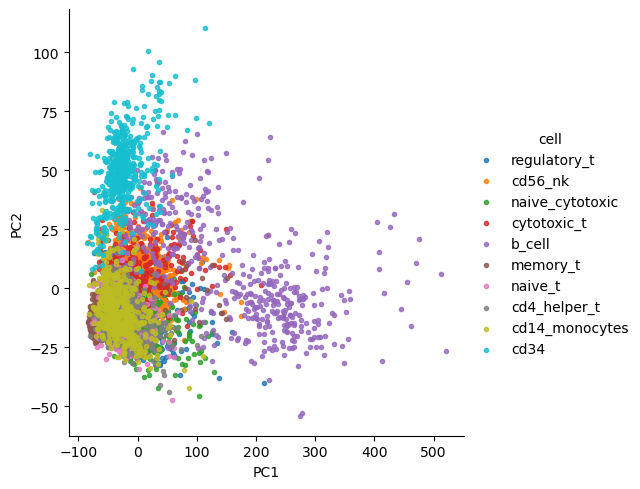

In [13]:
sns.lmplot(x="PC1", y="PC2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()

ドットの色が細胞種を表します。PCAを使うと、プロット上で異なる細胞種が密集してしまっているように見えますね。

次に、PCAの代わりにTSNEという手法を使って次元削減をしてみます。

In [14]:
%%time
model = TSNE(n_components=2, perplexity=20, n_iter=5000, verbose=1, random_state=0)
tsne = model.fit_transform(PC[:,0:9])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 5.875736
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.882736
[t-SNE] KL divergence after 5000 iterations: 1.172165
CPU times: user 4min 48s, sys: 1.35 s, total: 4min 49s
Wall time: 24.2 s


In [15]:
df = pd.DataFrame({ 'tSNE_1' : tsne[:,0], 'tSNE_2' : tsne[:,1], 'cell' : labels})
df.head()

,tSNE_1,tSNE_2,cell
0,22.894424,17.138462,regulatory_t
1,-3.101473,27.405436,regulatory_t
2,31.572876,-41.724659,regulatory_t
3,-17.855778,29.102798,regulatory_t
4,18.796272,19.191654,regulatory_t


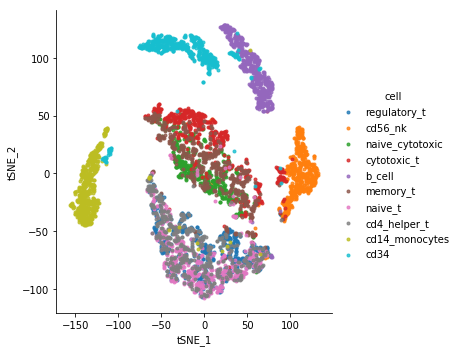

In [0]:
sns.lmplot(x="tSNE_1", y="tSNE_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()

次元削減手法を変えると、得られるプロットも全く違うものになることがわかります。
TSNEはPCAよりもきれいに分解してくれるようになりました。

最後に、UMAPという手法を用いて可視化してみましょう。

In [0]:
import umap
um = umap.UMAP().fit_transform(PC[:,0:9])

In [0]:
df = pd.DataFrame({ 'UMAP_1' : um[:,0], 'UMAP_2' : um[:,1], 'cell' : labels})
df.head()

,UMAP_1,UMAP_2,cell
0,-2.087032,6.527436,regulatory_t
1,-3.898192,5.645320,regulatory_t
2,-4.200012,1.749664,regulatory_t
3,-4.024286,3.966290,regulatory_t
4,-2.136032,5.425051,regulatory_t


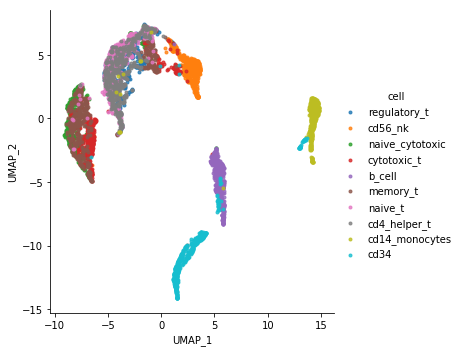

In [0]:
sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()

TSNEの結果とは異なりますが、こちらも綺麗に細胞を分解してくれているように見えます。

この次元削減はシングルセル解析の最初のステップで、実際の解析ではこの後に様々な解析を行うことになります。

興味がある人は中戸研究室の [１細胞解析技術講習会資料](https://singlecellanalysistutorial.readthedocs.io/en/latest/) も見てみてください。